# Homework: Transfer Learning & Domain Adaptation
##  Named Entity Recognition

Today we're gonna solve the problem of named entity recognition. Here's what it does in one picture:
![img](https://commons.bmstu.wiki/images/0/00/NER1.png)
[image source](https://bit.ly/2Pmg7L2)


For each word, in a sentence, your model should predict a named entity class: _person, organization, location_ or _miscellaneous_


## Data


### Source domain testset

Our train set consists from texts from different news sources. Therefore as source-domain testset we will use data from [CoNLL-2003 Shared Task](https://github.com/Franck-Dernoncourt/NeuroNER/blob/master/data/conll2003/en). More information about the task can be found [here](https://www.clips.uantwerpen.be/conll2003/ner/).

### Target domain (in-domain) data

As target-domain data we will use data from [WNUT17 Emerging and Rare entity recognition task](http://noisy-text.github.io/2017/emerging-rare-entities.html). This shared task focuses on identifying unusual, previously-unseen entities in the context of emerging discussions. The data were mined from mined from Twitter, Reddit,
YouTube and StackExchange. Results of different competitors of the task were published [here](https://noisy-text.github.io/2017/pdf/WNUT18.pdf).

### Named entity classes

* PER - _person_: names of people (e.g. Alexander S. Pushkin)
* ORG - _organization_: names of corporations (e.g. Yandex), names of non-profit organizations (e.g. UNICEF)
Google).
* LOC - _location_ : e.g. Russia
* MISC - _miscellaneous_ : other named entities including names of products (e.g. iPhone) and creative works (e.g. Bohemian Rhapsody)

### Evaluation metrics

As evaluation metrics we will F1 measure on exact matched NEs. It means that partially overlapped enitities of same class are considered as mismatch.
For example, LOC entities below is partially overlapped. And it is a mismatch:

__O, B-LOC, I-LOC, O__

__O, B-LOC, I-LOC, I-LOC__

Details can be found in the code of _conlleval.py_

### Data format

The format of all dataset follows popular [IOB format](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)). The B- prefix before a tag indicates that the tag is the beginning of a chunk, and an I- prefix before a tag indicates that the tag is inside a chunk. The B- tag is used only when a tag is followed by a tag of the same type without O tokens between them. An O tag indicates that a token belongs to no chunk.

The named entity labels include:
* __B-LOC__ - location - first token
* __I-LOC__ - location - subsequent tokens
* __B-ORG__ - organization - first token
* __O__ - not a named entity

### Part 1: dataset exploration

To load datasets we will use `huggingface/datasets` library:

https://huggingface.co/docs/datasets/

In [ ]:
import datasets
import typing as tp

In [ ]:
# reddit = datasets.load_dataset("reddit", cache_dir="/home/ubuntu/data2/nlp/", )

In [ ]:
conll = datasets.load_dataset("conll2003")
wnut = datasets.load_dataset("wnut_17")

This datasets is a actually `DatasetDict`s.

_Hint_ : to see class hierarchy we can use `getmro` function from `inspect` library.

In [ ]:
import inspect
inspect.getmro(type(conll))

In [ ]:
print(conll.keys(), wnut.keys())

Let's have a look at content of test part CONLL dataset:

In [ ]:
conll["test"].features

In [ ]:
conll["test"].dataset_size, len(conll["test"])

Let's have a look at single example in the dataset:

In [ ]:
conll["test"][50]

There is a fancy visualizer in `spacy` nlp library we can adapt for custom dataset.

In [ ]:
from spacy import displacy

In [ ]:
def ner_render(words: tp.Sequence[str], ner: tp.Sequence[str], title: tp.Optional[str] = None, **kwargs):
    pos = 0
    ents = []
    for word, tag in zip(words, ner):
        if tag.startswith('B'):
            ents.append({
                "start": pos,
                "end": pos + len(word),
                "label": tag.split("-")[1]
            })
        elif tag.startswith('I'):
            ents[-1]["end"] = pos + len(word)
        pos += (len(word) + 1)
    displacy.render({
        "text": " ".join(words),
        "ents": ents,
        "title": title
    }, style="ent", manual=True)
            

Voilà!

In [ ]:
ner_render(**conll["test"][50])
ner_render(**conll["test"][200])

Let's compare CONLL and WNUT named entity tags. We need to count each type of tags in both datasets

In [ ]:
from itertools import chain
from collections import Counter

# Count every type of tag in CONLL and WNUT datasets:

conll_tag_counts = Counter()
wnut_tag_counts = Counter()

# <YOUR CODE HERE>


In [ ]:
wnut_tag_counts

In [ ]:
conll_tag_counts

Thus, WNUT and CONLL have different set of NE tags (labels).

From WNUT description:

**person** –  Names  of  people  (e.g.Virginia Wade).   Don’t mark people that don’t have their own name.  Include punctuation in the middle ofnames.  Fictional people can be included, as long as they’re referred to by name (e.g.Harry Potter).

**location** –  Names  that  are  locations  (e.g. France).    Don’t  mark  locations  that  don’t  have their own name.  Include punctuation in the middle of names. Fictional locations can be included, as long as they’re referred to by name (e.g.Hogwarts)

**corporation** –  Names  of  corporations  (e.g.Google).   Don’t  mark  locations  that  don’t  have their own name. Include punctuation in the middle of names

**product** –  Name  of  products  (e.g. iPhone). Don’t  mark  products  that  don’t  have  their  own name. Include punctuation in the middle of names. Fictional  products  can  be  included,  as  long  as they’re referred to by name (e.g.Everlasting Gobstopper).  It’s got to be something you can touch, and it’s got to be the official name.

**creative-work** –  Names  of  creative  works (e.g.Bohemian Rhapsody). Include punctuation inthe middle of names. The work should be created by a human, and referred to by its specific name.

**group** – Names of groups (e.g.Nirvana, SanDiego  Padres). Don’t  mark  groups  that  don’t have a specific, unique name, or companies (which should be marked corporation).


We can match CONLL and WNUT labels using next rules:

In [ ]:
label_mapping = {
    'O': 'O',
    'B-location': 'B-LOC',
    'I-location': 'I-LOC',
    'B-group': 'B-ORG',
    'B-corporation': 'B-ORG',
    'B-person': 'B-PER',
    'B-creative-work': 'B-MISC',
    'B-product': 'B-MISC',
    'I-person': 'I-PER',
    'I-creative-work': 'I-MISC',
    'I-corporation': 'I-ORG',
    'I-group': 'I-ORG',
    'I-product': 'I-MISC'
}

In [ ]:
def convert_label_sequence(example: tp.Dict[str, tp.Any], label_mapping: tp.Dict[str, str]) -> tp.Dict[str, tp.Any]:
    converted_example = dict(**example)
    converted_example["ner"] = [label_mapping[label] for label in example["ner"]]
    return converted_example

In [ ]:
converted_wnut = wnut.map(lambda x: convert_label_sequence(x, label_mapping))

**Before:**

In [ ]:
ner_render(**wnut["train"][0])
ner_render(**wnut["train"][1])
ner_render(**wnut["train"][2])

**After label mapping:**

In [ ]:
ner_render(**converted_wnut["train"][0])
ner_render(**converted_wnut["train"][1])
ner_render(**converted_wnut["train"][2])

To visualize lexical differences between WNUT and CONLL let's use `scattertext` library.

In [ ]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
from IPython.display import IFrame
%matplotlib inline 

In [ ]:
# !pip3 install scattertext

In [ ]:
import scattertext as st
import pandas as pd

In [ ]:
conll_df = pd.DataFrame([{"text": " ".join(example["words"]), "ner": example["ner"], "dataset": "conll"} for example in conll["train"]])
wnut_df = pd.DataFrame([{"text": " ".join(example["words"]), "ner": example["ner"], "dataset": "wnut"} for example in converted_wnut["train"]])

In [ ]:
df = pd.concat([conll_df, wnut_df]).assign(
    parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences)
)

corpus = st.CorpusFromParsedDocuments(
    df, category_col='dataset', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

In [ ]:
html = st.produce_scattertext_explorer(
    corpus,
    category='conll', category_name='CONLL', not_category_name='WNUT',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=st.Scalers.dense_rank
)

with open("difference.html", "w") as outf:
    print(html, file=outf)

In [ ]:
IFrame("difference.html", width=1200, height=1000)

### Part 2: BERT sequence labeling recap (2 points)

https://huggingface.co/transformers/task_summary.html#named-entity-recognition

The sequence labeling task is a degenerate case of the seq2seq task: we need to map a sequence of words to a sequence of labels (tags) of **the same length**.

In case of BERT we want to get a vector of probabilities of labels for each input token. The simplest way to make it is just feed output token embeddings to Linear layer.

`transformers` class `BertForTokenClassification` works just like this.

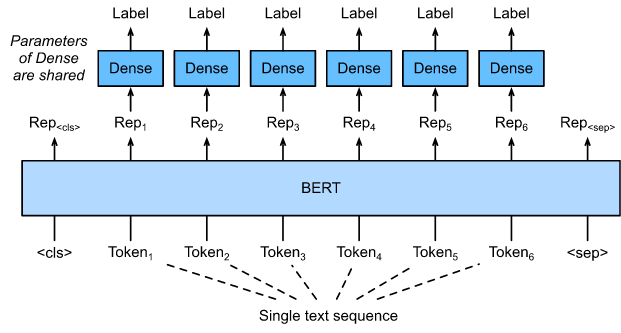

Image from FastAI article: https://d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html

#### 2.1 Load pre-trained BERT-based sequence tagger

In [ ]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

# Load pretrained model and tokenizer for English NER task (dslim/bert-base-NER)
# <YOUR CODE HERE>
# model = ...
# tokenizer = ...


Let's have a look at `BertForTokenClassification` class hierarchy

In [ ]:
inspect.getmro(type(model))

In `transformers.BertPreTrainedModel` there is an important attribute `config`. Let's have a look. 

In [ ]:
model.config

As mentioned above `BertForTokenClassification` = BERT + linear classifier

In [ ]:
model.classifier

In [ ]:
model.bert

Let's explore one exmaple from dataset:

In [ ]:
ner_render(**conll["test"][10])

Tokenizer call splits sequence of words to sequnce of word pieces (bpe units) and maps it to token ids.

In [ ]:
encoded = tokenizer(conll["test"][10]["words"], is_split_into_words=True)

In [ ]:
encoded

Here:

`input_ids` - indices of input sequence tokens in the vocabulary

`token_type_ids` - segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]: 0 corresponds to a sentence A token, 1 corresponds to a sentence B token

`attention_mask` - mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:

As we discussed above in sequence labeling task output sequence length should be equal to input sequence length.

Tokenizer can split single world to multiple pieces:

In [ ]:
print(f"Original sentence:\n---\n{' '.join(conll['test'][10]['words'])}")

tokenized = " ".join([tokenizer.ids_to_tokens[id_] for id_ in encoded["input_ids"]])
print(f"\nTokenized sentence:\n---\n{tokenized}")

# 

For example named entity `Takuya Takagi` transforms into `Ta ##ku ##ya Ta ##ka ##gi`. We need to preserve invariant: input sequence length = output sequence length. So sequence labels (tags) should be tokenized too.


```
Takuya Takagi -> Ta    ##ku   ##ya   Ta     ##ka    ##gi
   |     |        |     |       |     |      |        |
B-PER  I-PER    B-PER  I-PER  I-PER  I-PER  I-PER   I-PER 
```

Let's write function for it.

In [ ]:
def tokenize_and_preserve_tags(example: tp.Dict[str, tp.Any],
                               tokenizer: transformers.BertTokenizer,
                               label2id: tp.Dict[str, int],
                               tokenizer_params={}) -> tp.Dict[str, tp.Any]:
    # write your own function to split each pair of word-token to same number of pieces.
    encoded = tokenizer(example["words"], is_split_into_words=True, **tokenizer_params)
    encoded.update(example)
    
    # <YOUR CODE HERE>
    # encoded['labels'] = ...
    # encoded['text_labels'] = ...
    
    assert len(encoded['labels']) == len(encoded["input_ids"])
    return encoded
    

In [ ]:
test_sentence = "His name is Jerry Abrahamson"
test_example = {"words": test_sentence.split(" "), "ner": ["O", "O", "O", "B-PER", "I-PER"]}
test_result = tokenize_and_preserve_tags(test_example, tokenizer, model.config.label2id)

assert tokenizer.decode(test_result['input_ids']) == '[CLS] His name is Jerry Abrahamson [SEP]'

                                     #CLS     His  name is    Jerry    Abraham   ##son      SEP
assert test_result['text_labels'] == ['O'] + ["O", "O", "O", "B-PER", "I-PER",  "I-PER"] + ["O"]


In [ ]:
conll = conll.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, model.config.label2id))

In [ ]:
wnut = converted_wnut
wnut = wnut.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, model.config.label2id))

Next step is convert all numpy.arrays to torch.tensors:

In [ ]:
conll.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)
wnut.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)

In [ ]:
import torch

In [ ]:
conll["test"][:1]

To use `transformers.Dataset` with `torch.DataLoader` we need a custom function to pad sequences and make batches.

In [ ]:
from collections import defaultdict
class PadSequence:
    def __init__(self, padded_columns, device='cuda'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
                
        for key, val in padded_batch.items():
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch

In [ ]:
conll_test_dataloader = torch.utils.data.DataLoader(conll["test"], batch_size=4, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

Let's test it:

In [ ]:
test_batch = next(iter(conll_test_dataloader))
model_output = model(input_ids=test_batch["input_ids"],
                     token_type_ids=test_batch["token_type_ids"],
                     attention_mask=test_batch["attention_mask"],
                     labels=test_batch["labels"], return_dict=True)

In [ ]:
model_output.keys()

Model output contains only `loss` and `logits`. We need to write simple wrapper to convert raw logits to token sequence.

In [ ]:
class NamedEntityPredictor:
    def __init__(self,
                 model: transformers.BertForTokenClassification,
                 tokenizer: transformers.BertTokenizer,
                 id2label: tp.Optional[tp.Dict[str, int]] = None):
        self.model = model
        self.tokenizer = tokenizer
        self.id2label = model.config.id2label if id2label is None else id2label
    
    def predict(self, batch: tp.Dict[str, tp.Any]):
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(input_ids=batch["input_ids"],
                                      token_type_ids=batch["token_type_ids"],
                                      attention_mask=batch["attention_mask"],
                                      labels=batch["labels"],
                                      return_dict=True)
        indices = torch.argmax(model_output.logits, axis=2)
        indices = indices.detach().cpu().numpy()
        attention_mask = batch["attention_mask"].cpu().numpy()
        batch_size = len(batch["input_ids"])
        predicted_labels = []
        for i in range(batch_size):
            predicted_labels.append([self.id2label[id_] for id_ in indices[i][attention_mask[i] == 1]])
            
        return {
            "predicted_labels": predicted_labels,
            "loss": model_output.loss,
            "logits": model_output.logits
        }
            
        

In [ ]:
ner = NamedEntityPredictor(model, tokenizer)
test_prediction = ner.predict(test_batch)
assert test_prediction['predicted_labels'][2] == list(test_batch["text_labels"][2])

In [ ]:
import tqdm

Let's measure quality of NER for in-domain and out-domain testset.

To compare models we can use F1 measure. There is a great package `seqeval` to make such quality measurements.

In [ ]:
#!pip3 install seqeval

In [ ]:
conll_test_dataloader = torch.utils.data.DataLoader(conll["test"], batch_size=16, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
wnut_test_dataloader = torch.utils.data.DataLoader(wnut["test"], batch_size=16, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

In [ ]:
ner = NamedEntityPredictor(model, tokenizer)
predicted_labels = {"wnut_test": [], "conll_test": []}

for batch in tqdm.tqdm_notebook(conll_test_dataloader):
    predicted_labels["conll_test"].extend(ner.predict(batch)["predicted_labels"])
    
for batch in tqdm.tqdm_notebook(wnut_test_dataloader):
    predicted_labels["wnut_test"].extend(ner.predict(batch)["predicted_labels"])

In [ ]:
import seqeval

In [ ]:
conll_report = seqeval.metrics.classification_report(y_true=[list(example["text_labels"]) for example in conll["test"]],
                                                     y_pred=predicted_labels["conll_test"])

In [ ]:
wnut_report = seqeval.metrics.classification_report(y_true=[list(example["text_labels"]) for example in wnut["test"]],
                                                    y_pred=predicted_labels["wnut_test"])

In [ ]:
print(f"CONLL:\n {conll_report}")
print(f"WNUT:\n {wnut_report}")

As we can see WNUT model perfomance is poor. Let's test hypothesis that for CONLL-like inputs NER quality will be higher.

To make this we will train a simple log-regression to classify sentences between two datasets based on their sentence embeddings.

The sentence embeddings can be obtained from [CLS] token embedding.

For classification we will train vanilla sklearn log-regression. Just like on picture below, but we will use ordinary BERT for sentence embeddings.

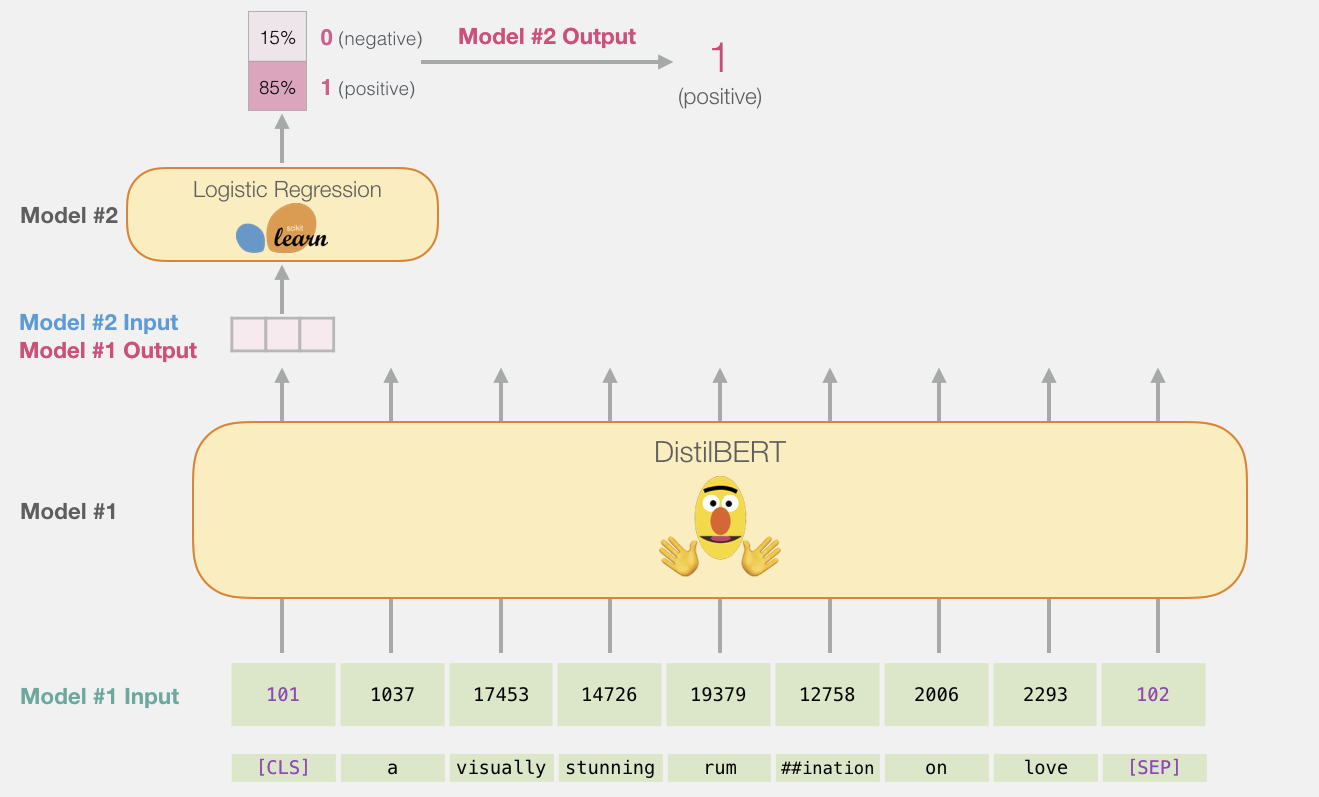

Picture from great [Jay Alammar's blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

In [ ]:
#!pip3 install nltk

In [ ]:
def get_sentence_embeddings(model, batch):
    model.eval()
    with torch.no_grad():
        return model.bert(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"],
                          return_dict=True)["last_hidden_state"].cpu().numpy()[:,0]

In [ ]:
X = []
Y = []

conll_train_dataloader = torch.utils.data.DataLoader(conll["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

for batch in tqdm.tqdm_notebook(conll_train_dataloader):
    X.append(get_sentence_embeddings(model, batch))
    Y.extend([0] * len(batch["input_ids"]))
    
for batch in tqdm.tqdm_notebook(wnut_train_dataloader):
    X.append(get_sentence_embeddings(model, batch))
    Y.extend([1] * len(batch["input_ids"]))

In [ ]:
import numpy as np

In [ ]:
X = np.concatenate(X)
Y = np.array(Y)

In [ ]:
import sklearn

In [ ]:
dataset_classifier = sklearn.linear_model.LogisticRegression(max_iter=1000)
dataset_classifier.fit(X, Y)

In [ ]:
wnut_test_scores = []

wnut_test_dataloader = torch.utils.data.DataLoader(wnut["test"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
for batch in tqdm.tqdm_notebook(wnut_test_dataloader):
    x = get_sentence_embeddings(model, batch)
    wnut_test_scores.append(dataset_classifier.predict_proba(x)[:,1])
    

In [ ]:
wnut_test_scores = np.concatenate(wnut_test_scores)

In [ ]:
import matplotlib.pyplot as plt
%pylab inline

In [ ]:
plt.hist(wnut_test_scores)
plt.xlabel("WNUT score.")
plt.show()

In [ ]:
score_indices = np.argsort(wnut_test_scores)

In [ ]:
wnut_predicted_labels = np.array(predicted_labels["wnut_test"])[np.argsort(wnut_test_scores)]

In [ ]:
wnut_true_labels = np.array([list(example["text_labels"]) for example in wnut["test"]])[np.argsort(wnut_test_scores)]

After sorting true and predicted labels based on WNUT score let split them into 5 chunks and measure F1. 

In [ ]:
predicted_splits = np.array_split(wnut_predicted_labels, 5, )
true_splits = np.array_split(wnut_true_labels, 5)
score_splits = np.array_split(wnut_test_scores[np.argsort(wnut_test_scores)], 5)

In [ ]:
print("score\tf1")
for scores, true_split, predicted_split in zip(score_splits, true_splits, predicted_splits):
    mean_score = np.mean(scores)
    f1 = seqeval.metrics.f1_score(true_split, predicted_split)
    print(f"{mean_score:.3f}\t{f1:.3f}")

So:

**The bigger domain shift the lower f1 measure**

### Part 3: domain adaptation

*HINT:* In this task you will have to run a multiple experiments and compare metric curves between them. While you *could* do everything in pure matplotlib, your notebook will quickly spiral into a hot mess of unordered plots and irreproducible results.

In order to manage all your plots and results, we recommend using specialized frameworks. You could use `tensorboardX` or `visdom`(even [in colab](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab)), but they only work on your local machine and do not let you share your results with colleagues.

If you want to show off your awesome learning curves for everyone to envy, you could also use cloud-based services such as [weights and biases](https://www.wandb.com/), [comet.ml](https://www.comet.ml/site/) or [neptune.ai](https://neptune.ai/) (recommended). We encourage you to try them for this homework, but you're still free to use any library you want.

If you're interested, here's how to set up your project in Neptune:
1. Sign up at [neptune.ai](https://neptune.ai/) and create a public project, e.g. `ysda-hw5`
2. Install neptune: `pip install neptune-client`
3. Initialize your project:
```python
import neptune
neptune.init(f'{USERNAME}/ysda-hw5',
             api_token=API_TOKEN)
```
3. Set the experiment parameters (any and all values that you want to keep track of)
```python

PARAMS = {'decay_factor': 0.7,
          'n_iterations': 117,
          'lr': 0.33,
          'training-data': 'wnut',
          'tokenizer': 'default'
          'additional_info': 'Removed some suspicious training samples'
         }

neptune.create_experiment(name='my_first_experiment',
                          params=PARAMS)
```

4. Dump your metrics (in training loop):

```python
# log some metrics
for i in range(1, PARAMS['n_iterations']):
    neptune.log_metric('iteration', i)
    neptune.log_metric('loss', PARAMS['decay_factor'] / i ** 0.5)
    neptune.log_text('text_info', 'some value {}'.format(0.95 * i ** 2))

# add tag to the experiment
neptune.append_tag('quick_start')

# log some images
for j in range(5):
    array = np.random.rand(10, 10, 3)*255
    array = np.repeat(array, 30, 0)
    array = np.repeat(array, 30, 1)
    neptune.log_image('mosaics', array)
```

#### 3.0 Intro

**Your task:**

Fine-tune your model on in-domain data, investigate how it affects model quality (both in-domain and out-of-domain). Find out the optimal training strategy.


**Evaluation:**

The main performance metric for NER is F1-score. You can use the canonic implementation from `seqeval.metrics.f1_score`. For simplicity, please measure F1 score with the same tokenization as used above, i.e. without removing BPE-segments or special tokens ([CLS] and [SEP]).

You will need to track validation metrics on both in-domain (WNUT) and out-of-domain (CONLL) test sets. Here's how  you could do that:

```python
ner = NamedEntityPredictor(model, tokenizer)
predicted_labels = {"wnut_test": [], "conll_test": []}

for batch in tqdm.tqdm_notebook(conll_test_dataloader):
    predicted_labels["conll_test"].extend(ner.predict(batch)["predicted_labels"])
    
for batch in tqdm.tqdm_notebook(wnut_test_dataloader):
    predicted_labels["wnut_test"].extend(ner.predict(batch)["predicted_labels"])
    
    
conll_f1 = seqeval.metrics.f1_score(y_true=[list(example["text_labels"])
                                                             for example in conll["test"]],
                                                     y_pred=predicted_labels["conll_test"])

wnut_f1 = seqeval.metrics.f1_score(y_true=[list(example["text_labels"])
                                                             for example in wnut["test"]],
                                                     y_pred=predicted_labels["wnut_test"])

```

**Models:**

Feel free to use any pre-trained transformer of your choosing. However, we recommend that you start with `dslim/bert-base-NER` to avoid potential side effects.


**Data:**

Use WNUT and CONLL datasets loaded above, as long as any additional data that you see fit.


**Grading:**

To get the maximum grade, you will need to run several experiments for parameter tuning and summarize your results in a short report.

#### 3.1 Supervised DA [4 points]

##### 3.1.1 In-domain fine-tuning [2 points]

**Your task:**

1. Fine-tune your entire model (all layers) using `wnut["train"]`
2. Fine-tune the model again using only the final layer (`model.classifier`)
3. Compare results

**Hint:**
In order to "freeze" some of the model parameters and prevent fine-tuning, you can manually set `requires_grad=False` for all parameters and then manually set it back to True for the ones you want to train (more info [here](https://huggingface.co/transformers/training.html#pytorch)):

```python
for param in model.bert.parameters():
    param.requires_grad = False
```


##### 3.1.2  Resampling methods [2 points]

1. Train a binary classifier that tells `conll["train"]` apart from `wnut["train"]`.
2. Use the classifier probability to select top-25% samples from `conll["train"]` that are most similar to `wnut`.
  - note: use leave-one-out predictions: split `conll["train"]+wnut["train"]` into N chunks;
  - for each chunk, train a classifier on all other chunks and make predictions for the remaining chunk.
3. Try fine-tuning your primary model using 25% best samples;
4. Alternative: fine-tune using the entire `conll["train"]` dataset with sample weights. Use $1 + p_i$ weights where $p_i$ is the probability of `wnut` for i-th  according to your classifier.

#### 3.2 Unsupervised DA [6 points]
**Your task:**

Train and evaluate domain adaptation using unlabeled data.

##### 3.2.1 Proxy-labels methods [2 points]

1. Use pre-trained bert to make predictions for all `wnut["train"]` samples,
2. Select top-50% training samples where the average probability of the predicted is the highest,
3. Fine-tune BERT using the proxy-labelled data

##### 3.2.2 Unsupervised pretraining [4 points]

1. Download the reddit dataset

```python
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/reddit_sample.json
reddit = datasets.load_dataset('json', data_files='/home/ubuntu/data2/nlp/reddit_sample.json')

# alternative download link: https://www.dropbox.com/s/zmiv3oq7girdvla/reddit_sample.json?dl=1
```
2. Use the method from (3.1.2) to select 100,000 best training samples from reddit data (that most resemble `wnut["train"]`)
3. Fine-tune the BERT model on those samples using Masked LM objective (see `transformers.BertForMaskedLM`)
4. Use the resulting model to classify `wnut["train"]` with the best fine-tuning strategy from previous experiments.

Feel free to try any alternative models, fine-tuning methods and datasets. As usual, we will award bonus points for extra experiments and analysis.

Good hunting!

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```





In [ ]:
# <a whole lot of your code here>

### Bonus assignment: Model Compression

![img](https://i.imgur.com/yOHM1ZNl.png?1)

Imagine you want to deploy your model as a part of your "smart speaker" device (such as Amazon Echo / Yandex Alisa / etc). Unfortunately, it currently takes over 400MB of disk (and RAM) space to simply store your model. Can you do something about that?

Note: there are multiple ways to solve this assignment with different award scales. For instance, a simple solution with float16 precision will be awarded 3 points. However, if you combine several methods and get a *really* competitive solution, you will get significantly more (e.g. >>10 points).

**Your task** is to design a way to *save your model into a checkpoint* and measure two quantities:
* The size of the resulting checkpoint (megabytes)
* F1 scores on in- and out-of-domain test sets
* Model throughput (samples/s) in your CPU configuration

The F1 scores must be obtained using only the checkpoint and your de-serialization code (<1MB source, <60s cpu). Loading extra data is off-limits. So, for instance, you *can* implement a custom checkpoint format, but you can *not* fetch a separate pre-trained model unless it is stored inside your checkpoint.


Here's what you can try:
* __Half precision:__ by far the simplest way of downsizing your model: cast it to float16.
* __Quantization:__ pytorch has builtin support for [quantized tensors](https://pytorch.org/docs/stable/quantization.html), but you can write your own implementation to prioritize model size.
* __Distillation:__ before fine-tuning your model, you can deliberately change its architecture to use up less disk space.
* __Sparsification:__ you can prune off unnecessary weights, units or even layers. Use [this code](https://github.com/moskomule/l0.pytorch/blob/master/l0module.py) for inspiration.
* __Imagination:__ there's plenty of other interesting ideas you can try. For instance, you can choose a different BERT model, or train an ensemble of models and distill them into one to improve quality.

Sky is the limit.


In [ ]:
# <Your completely optional code here>